## Import Library

In [2]:
from pyspark.sql import SparkSession, types
from pyspark.sql import functions as F
import os
from dotenv import load_dotenv
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from functools import reduce
import seaborn as sns
import matplotlib.pyplot as plt
import io 
from google.cloud import storage

load_dotenv()

True

## Setup Sparkstandalone Session

In [3]:
spark = SparkSession \
    .builder \
    .master('spark://localhost:7077') \
    .config("spark.jars.packages", "com.google.cloud.spark:spark-bigquery-with-dependencies_2.12:0.36.1") \
    .config("spark.jars", "https://storage.googleapis.com/hadoop-lib/gcs/gcs-connector-hadoop3-latest.jar") \
    .config("spark.hadoop.fs.gs.impl", "com.google.cloud.hadoop.fs.gcs.GoogleHadoopFileSystem") \
    .config("spark.hadoop.fs.AbstractFileSystem.gs.impl", "com.google.cloud.hadoop.fs.gcs.GoogleHadoopFS") \
    .config("spark.hadoop.google.cloud.auth.service.account.enable", "true") \
    .config("spark.hadoop.fs.gs.impl", "com.google.cloud.hadoop.fs.gcs.GoogleHadoopFileSystem") \
    .config("spark.hadoop.fs.AbstractFileSystem.gs.impl", "com.google.cloud.hadoop.fs.gcs.GoogleHadoopFS") \
    .config("spark.hadoop.google.cloud.auth.service.account.enable", "true") \
    .config("spark.hadoop.google.cloud.auth.type", "SERVICE_ACCOUNT_JSON_KEYFILE") \
    .config("spark.hadoop.fs.gs.project.id", os.getenv('PROJECT_ID')) \
    .appName("fisiology_spark") \
    .getOrCreate()

:: loading settings :: url = jar:file:/home/Bagas/spark/spark-3.5.5-bin-hadoop3/jars/ivy-2.5.1.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /home/Bagas/.ivy2/cache
The jars for the packages stored in: /home/Bagas/.ivy2/jars
com.google.cloud.spark#spark-bigquery-with-dependencies_2.12 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-b6e2c296-42b1-4033-950e-479920161cad;1.0
	confs: [default]
	found com.google.cloud.spark#spark-bigquery-with-dependencies_2.12;0.36.1 in central
:: resolution report :: resolve 119ms :: artifacts dl 4ms
	:: modules in use:
	com.google.cloud.spark#spark-bigquery-with-dependencies_2.12;0.36.1 from central in [default]
	---------------------------------------------------------------------
	|                  |            modules            ||   artifacts   |
	|       conf       | number| search|dwnlded|evicted|| number|dwnlded|
	---------------------------------------------------------------------
	|      default     |   1   |   0   |   0   |   0   ||   1   |   0   |
	-------------------------------------------------------------------

## Connection to GCS Test

In [4]:
base_path = 'gs://project-abd/raw/class_wearable_data/'

def sample_wearable(class_id, participant_id):
    session_path = os.path.join(base_path, str(class_id), str(participant_id))
    print(f'Processing : {session_path}..')
    
    sensor_map = {}
    sensors = {'HR.csv': 'HR', 'TEMP.csv': 'TEMP'}
    
    for file_name, sensor_prefix in sensors.items():
        file_path = os.path.join(session_path, file_name)
        try:
            df_sensor = pd.read_csv(file_path, header=None, names=[sensor_prefix, 'Time'])
            
            df_sensor.dropna(subset=['Time'], inplace=True)
            df_sensor['Time'] = pd.to_datetime(df_sensor['Time'], errors='coerce')
            df_sensor[sensor_prefix] = pd.to_numeric(df_sensor[sensor_prefix], errors='coerce')
            df_sensor.dropna(subset=[sensor_prefix], inplace=True)
            
            if not df_sensor.empty:
                df_sensor.set_index('Time', inplace=True)
                sensor_map[sensor_prefix] = df_sensor[[sensor_prefix]]

        except FileNotFoundError:
            print(f'File not found: {file_path}')
        except Exception as e:
            print(f'Error processing {file_path}: {e}')
    
    if not sensor_map:
        return pd.DataFrame()
    
    all_features = []
    for sensor_prefix, sensor_df in sensor_map.items():
        if not sensor_df.empty and not sensor_df.isnull().all().all():
            features = sensor_df.resample('5min').mean().reset_index()
            features.columns = ['time', f'{sensor_prefix}_mean']
            all_features.append(features.set_index('time'))

    if not all_features:
        return pd.DataFrame()

    final_features_pd = pd.concat(all_features, axis=1).reset_index()
    final_features_pd['time'] =   final_features_pd['time'].dt.strftime('%H:%M:%S')
    final_features_pd['participant_id'] = participant_id
    final_features_pd['class_id'] = class_id

    return final_features_pd

In [5]:
test = sample_wearable(1, 1)
test.head()

Processing : gs://project-abd/raw/class_wearable_data/1/1..


/tmp/ipykernel_2124/233987190.py:16: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_sensor['Time'] = pd.to_datetime(df_sensor['Time'], errors='coerce')
/tmp/ipykernel_2124/233987190.py:16: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_sensor['Time'] = pd.to_datetime(df_sensor['Time'], errors='coerce')


,time,HR_mean,TEMP_mean,participant_id,class_id
0,09:20:00,101.968507,18.796667,1,1
1,09:25:00,112.202900,18.799200,1,1
2,09:30:00,110.074467,18.782200,1,1
3,09:35:00,124.705167,18.653233,1,1


## Load Data

In [6]:
base_path = 'gs://project-abd/raw/class_wearable_data/'

schema = types.StructType([
    types.StructField('value', types.FloatType(), True),
    types.StructField('Time', types.TimestampType(), True)
])

hr = spark.read.schema(schema).csv(base_path + '/*/*/HR.csv')
temp = spark.read.schema(schema).csv(base_path + '/*/*/TEMP.csv')
eda = spark.read.schema(schema).csv(base_path + '/*/*/EDA.csv')
ibi = spark.read.schema(schema).csv(base_path + '/*/*/IBI.csv')
bvp = spark.read.schema(schema).csv(base_path + '/*/*/BVP.csv')

## Preprocess Data

In [7]:
def extract_id(df):
    df = df.withColumn('class_id', F.regexp_extract(F.input_file_name(),r'class_wearable_data/(\d+)/',1).cast('int'))
    df = df.withColumn('participant_id', F.regexp_extract(F.input_file_name(),r'class_wearable_data/\d+/(\d+)/',1).cast('int'))
    return df

In [8]:
hr = extract_id(hr)
temp = extract_id(temp)
eda = extract_id(eda)
ibi = extract_id(ibi)
bvp = extract_id(bvp)

In [9]:
hr.show(5)

+-----+-------------------+--------+--------------+
|value|               Time|class_id|participant_id|
+-----+-------------------+--------+--------------+
| NULL|               NULL|     213|            19|
| 92.0|2025-06-02 09:00:01|     213|            19|
|91.35|2025-06-02 09:00:02|     213|            19|
|90.73|2025-06-02 09:00:03|     213|            19|
|90.08|2025-06-02 09:00:04|     213|            19|
+-----+-------------------+--------+--------------+
only showing top 5 rows



In [10]:
def format_time(df):
    return df.withColumn('time_format',
                         F.date_format('Time','HH:mm:ss')).drop('Time')

hr_time = format_time(hr)
temp_time = format_time(temp)
eda_time = format_time(eda)
ibi_time = format_time(ibi)
bvp_time = format_time(bvp)

In [11]:
hr_time.show(5)

+-----+--------+--------------+-----------+
|value|class_id|participant_id|time_format|
+-----+--------+--------------+-----------+
| NULL|     213|            19|       NULL|
| 92.0|     213|            19|   09:00:01|
|91.35|     213|            19|   09:00:02|
|90.73|     213|            19|   09:00:03|
|90.08|     213|            19|   09:00:04|
+-----+--------+--------------+-----------+
only showing top 5 rows



In [12]:
def agg_sensor(df, alias):
    return df.groupby('class_id', 'participant_id', F.window('time_format','5 minutes')
                    ).agg(F.mean('value').alias(alias))

hr_agg = agg_sensor(hr_time, 'hr_mean')
temp_agg = agg_sensor(temp_time, 'temp_mean')
eda_agg = agg_sensor(eda_time, 'eda_mean')
ibi_agg = agg_sensor(ibi_time, 'ibi_mean')
bvp_agg = agg_sensor(bvp_time, 'bvp_mean')

In [13]:
df_to_join = [hr_agg, temp_agg, eda_agg, ibi_agg, bvp_agg]
df_join = reduce(lambda left,right:
    left.join(right, on=
              ['class_id',
               'participant_id',
               'window'], how='outer'),
    df_to_join)

In [14]:
final_df = df_join.withColumn('time', F.col('window').start).withColumn('time_format', F.date_format('time', 'HH:mm:ss')) \
    .select('class_id', 'participant_id', 'time_format','hr_mean', 'temp_mean', 'eda_mean', 'ibi_mean', 'bvp_mean'
).orderBy('class_id', 'participant_id', 'time')

final_df.show(5)

+--------+--------------+-----------+------------------+------------------+--------------------+-------------------+--------------------+
|class_id|participant_id|time_format|           hr_mean|         temp_mean|            eda_mean|           ibi_mean|            bvp_mean|
+--------+--------------+-----------+------------------+------------------+--------------------+-------------------+--------------------+
|       1|             1|   09:20:00|101.96850751051262| 18.79666699303521|0.001454626731881...|0.46877134839693707|0.005812729376985872|
|       1|             1|   09:25:00|112.20290006001791| 18.79920024236043|3.533424931811168...|0.38022567331790924| 0.01111510058719432|
|       1|             1|   09:30:00|110.07446683247885|18.782200450897218|3.661524929339066E-4| 0.3854343295097351|-0.01442968695181...|
|       1|             1|   09:35:00| 124.7051665242513| 18.65323377609253|2.006899961270392E-4|0.38790275516668205|6.333332597084033E-4|
|       1|             2|   09:20:

In [15]:
final_df.coalesce(1).write.option("header", True).mode('overwrite').csv("/home/Bagas/project/dataset/fisiology_output")

## EDA 

In [16]:
final_df.describe(['hr_mean', 'temp_mean', 'eda_mean', 'ibi_mean', 'bvp_mean']).show()

25/06/02 06:38:23 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+-------+------------------+------------------+-----------------+------------------+--------------------+
|summary|           hr_mean|         temp_mean|         eda_mean|          ibi_mean|            bvp_mean|
+-------+------------------+------------------+-----------------+------------------+--------------------+
|  count|             12413|             12413|            12349|             10479|               12414|
|   mean| 86.83354712633137| 31.52723853824994|1.144084654385367|0.7605375133657025|0.009647823618635504|
| stddev|14.063941496792594| 3.141786551346176|3.084032364776104|0.1415570370534735|  1.5541281532113587|
|    min|  52.9539333597819|17.495679283478484|              0.0|0.3125140070915222| -20.227012599750264|
|    max|200.02836634318035| 37.14290031433106| 58.3393748442332| 1.484442949295044|  170.29739180855128|
+-------+------------------+------------------+-----------------+------------------+--------------------+



In [17]:
df_pd = final_df.toPandas()

def tren_line(id,data) :
    sns.lineplot(data=df_pd[df_pd['participant_id'] == {id}], x = df_pd['time_format'], y = df_pd[f'{data}']) 
    plt.title(f'Tren Line for {data} for participant {id}')
    plt.show()

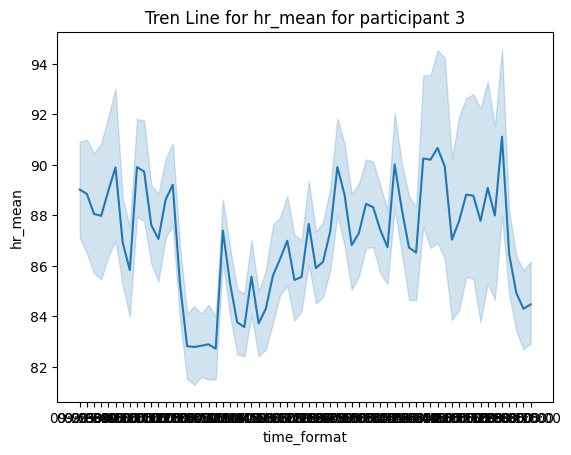

In [18]:
tren_line(3, 'hr_mean')

In [19]:
df_pd[['hr_mean', 'temp_mean', 'eda_mean', 'ibi_mean', 'bvp_mean']].corr()

,hr_mean,temp_mean,eda_mean,ibi_mean,bvp_mean
hr_mean,1.000000,-0.346460,0.158734,-0.595660,-0.002049
temp_mean,-0.346460,1.000000,0.130721,0.218071,-0.003338
eda_mean,0.158734,0.130721,1.000000,-0.249117,-0.005300
ibi_mean,-0.595660,0.218071,-0.249117,1.000000,-0.009277
bvp_mean,-0.002049,-0.003338,-0.005300,-0.009277,1.000000


In [20]:
csv_buffer = io.StringIO()
df_pd.to_csv(csv_buffer, index=False)
csv_data = csv_buffer.getvalue()
csv_buffer.close()

In [23]:
client = storage.Client()
os.environ['GOOGLE_APPLICATION_CREDENTIALS']=os.getenv('CREDENTIAL')

In [24]:
bucket = client.get_bucket('project-abd')
destination_file = 'notebook-data/fisiology.csv'
blob_csv = bucket.blob(destination_file)
blob_csv.upload_from_string(csv_data, content_type='text/csv')
print(f"DataFrame uploaded to gs://{bucket}/{destination_file} as CSV")

DataFrame uploaded to gs://<Bucket: project-abd>/notebook-data/fisiology.csv as CSV
